# Table S3. SHAPE reactivity and Shannon entropy
1. count reads
2. select library
3. get mutation rates
4. calculate reactivity
5. calculate Shannon entropy
6. build table

In [3]:
import time
today = time.strftime('%Y-%m-%d')
name = 'S. Chan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by S. Chan Baek at 2024-01-19.


In [4]:
HOME = '/casa/bsc/projects/2_Structure-of-pri/2007_paper_prep'
%cd $HOME

/casa/bsc/projects/2_Structure-of-pri/2007_paper_prep


In [5]:
from __future__ import division
from collections import Counter, defaultdict
from os import path, listdir
from itertools import groupby
import pandas as pd
import numpy as np
import re
import gzip
%matplotlib inline

In [6]:
# import sys; sys.path.append('/casa/bsc/notebooks/')
# from basic import gen_result_dir
# from util import *
# resultpath = gen_result_dir('results/')
# print 'resultpath:', resultpath

In [9]:
LIBRARIES = [ 'rep1', 'rep2-1', 'rep2-2', 'rep2-3' ]
CONDITIONS = [ '+1m7', '-1m7', 'dc' ]
CONTROLS = [ 'IRES-domainII', 'U1-snRNA', 'Yeast-tRNAasp']

In [7]:
s1 = pd.read_csv('publication/TableS1__Pri-miRNAs_selected_for_SHAPE-MaP.csv',index_col=0)
s2 = pd.read_csv('publication/TableS2__Constructs_used_in_this_study.csv',index_col=0)
constseqs = s2['Construct sequence'].to_dict()
print len(s1.index), len(s2.index)

519 522


In [52]:
datapath = '/casa/bsc/bin/RNAstructure/data_tables'
partition = '/casa/bsc/bin/RNAstructure/exe/partition'
probplot = '/casa/bsc/bin/RNAstructure/exe/ProbabilityPlot'
%env DATAPATH $datapath

env: DATAPATH=/casa/bsc/bin/RNAstructure/data_tables


---
### 1. count reads
- Sam files were generated by Snakefile

In [10]:
cnttbl = pd.DataFrame()
for lib in LIBRARIES:
    for cond in CONDITIONS:
        mapf = 'preprocessing/alignments/%s_%s.sam' % (lib,cond)
        mappedmirs = !cut -f3 $mapf
        cnttbl['%s_%s' % (lib,cond)] = pd.Series(Counter(mappedmirs))/2
cnttbl = cnttbl.fillna(0).astype(int).sort_index()
cnttbl.head(3)

,rep1_+1m7,rep1_-1m7,rep1_dc,rep2-1_+1m7,rep2-1_-1m7,rep2-1_dc,rep2-2_+1m7,rep2-2_-1m7,rep2-2_dc,rep2-3_+1m7,rep2-3_-1m7,rep2-3_dc
IRES-domainII,68162,52046,56724,234321,192967,290763,246346,112592,223690,226377,120209,240482
S-domain,82648,47486,43915,283719,204319,246974,209722,111069,173452,221193,101096,193472
TPP-riboswitch,36619,23572,27069,127542,83030,124692,129133,53594,94876,135595,53043,97980


In [16]:
cnttbl = cnttbl.reindex(s2.index).fillna(0)
cnttbl.to_csv('publication/TableS3_1__Read_counts.csv')
#cnttbl = pd.read_csv('publication/TableS3_1__Read_counts.csv', index_col=0)

### 2. select library

In [13]:
RCUT_PD = 500
RCUT_M = 100

In [14]:
meancnts = {}
for lib in LIBRARIES:
    meancnts[lib] = cnttbl[['%s_%s'%(lib,c) for c in CONDITIONS]].mean(axis=1)

In [20]:
maxlib = {}
for m in cnttbl.index:
    sufflibs = [lib for lib in LIBRARIES if cnttbl.loc[m,'%s_+1m7'%lib]>=RCUT_PD and 
                                            cnttbl.loc[m,'%s_-1m7'%lib]>=RCUT_M and
                                            cnttbl.loc[m,'%s_dc'%lib]>=RCUT_PD ]
    if sufflibs:
        maxlib[m] = max(sufflibs,key=lambda x:meancnts[x][m])
print len(maxlib)

481


### 3. get mutation rates
- csv files were generated by Snakefile

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline

In [24]:
def get_info_from_csv(csv, item): # item is 'mutation rate' or 'depth'
    csvtbl = pd.read_csv(csv, index_col=2)
    infos = [ float(r) for r in csvtbl.loc[item].values[2:-1] ]
    return infos

#### Overall mutation rates and depths

In [25]:
mrplus, mrminus, mrdc = [], [], []
for m in maxlib.keys():
    plus = 'shape/%s/counted_mutations/+1m7_%s.csv' % (maxlib[m],m)
    minus = 'shape/%s/counted_mutations/-1m7_%s.csv' % (maxlib[m],m)
    dc = 'shape/%s/counted_mutations/dc_%s.csv' % (maxlib[m],m)
    mrplus.extend(get_info_from_csv(plus, 'mutation rate'))
    mrminus.extend(get_info_from_csv(minus, 'mutation rate'))
    mrdc.extend(get_info_from_csv(dc, 'mutation rate'))
print len(mrplus)

60084


In [26]:
print np.median(mrplus), np.median(mrminus), np.median(mrdc)
print np.average(mrplus), np.average(mrminus), np.average(mrdc)

0.0031848350772634 0.00204461545217785 0.0031661855755374
0.005186846796564269 0.0039940873168047486 0.004870497640885915


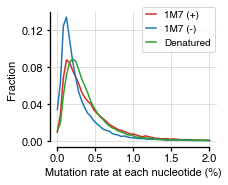

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(3,2.5))

xs = np.arange(0,2.01,.04)
bins = np.arange(0,2.05,.04)-.01

ysp = np.histogram(np.array(mrplus)*100,bins=bins)[0]/len(mrplus)
ysm = np.histogram(np.array(mrminus)*100,bins=bins)[0]/len(mrplus)
ysd = np.histogram(np.array(mrdc)*100,bins=bins)[0]/len(mrplus)
ax.plot(xs,ysp,color='tab:red',label='1M7 (+)',zorder=2)
ax.plot(xs,ysm,color='tab:blue',label='1M7 (-)',zorder=2)
ax.plot(xs,ysd,color='tab:green',label='Denatured',zorder=2)

ax.set_xlabel('Mutation rate at each nucleotide (%)')
ax.set_ylabel('Fraction')
ax.set_yticks(np.arange(0,.13,.04))

ax.spines['bottom'].set_bounds(0,2)
ax.spines['left'].set_bounds(0,.14)
ax.legend(handlelength=1,loc=(.55,.7))
ax.grid(ls='-')

In [29]:
dpplus, dpminus, dpdc = [], [], []
for m in maxlib.keys():
    plus = 'shape/%s/counted_mutations/+1m7_%s.csv' % (maxlib[m],m)
    minus = 'shape/%s/counted_mutations/-1m7_%s.csv' % (maxlib[m],m)
    dc = 'shape/%s/counted_mutations/dc_%s.csv' % (maxlib[m],m)
    dpplus.append(max(get_info_from_csv(plus, 'depth')))
    dpminus.append(max(get_info_from_csv(minus, 'depth')))
    dpdc.append(max(get_info_from_csv(dc, 'depth')))
print len(dpplus)

481


In [30]:
print np.median(dpplus), np.median(dpminus), np.median(dpdc)

52069.0 31670.0 52829.0


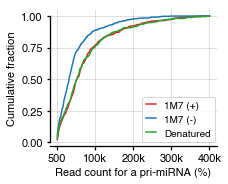

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(3,2.5))

xs = np.arange(0,400001,1000)+500
bins = np.arange(0,401001,1000)-500+500

ysp = np.histogram(dpplus,bins=bins)[0]
ysm = np.histogram(dpminus,bins=bins)[0]
ysd = np.histogram(dpdc,bins=bins)[0]
ax.plot(xs,ysp.cumsum()/ysp.sum(),color='tab:red',label='1M7 (+)',zorder=2)
ax.plot(xs,ysm.cumsum()/ysm.sum(),color='tab:blue',label='1M7 (-)',zorder=2)
ax.plot(xs,ysd.cumsum()/ysd.sum(),color='tab:green',label='Denatured',zorder=2)

ax.set_xlabel('Read count for a pri-miRNA (%)')
ax.set_ylabel('Cumulative fraction')
ax.set_xticks([500]+range(100000,400001,100000))
ax.set_xticklabels([500,'100k','200k','300k','400k'])
ax.set_yticks(np.arange(0,1.1,.25))
ax.spines['left'].set_bounds(0,1)
ax.legend(handlelength=1,loc=(.55,.03))
ax.grid(ls='-')

#### Individual mutation rates

In [32]:
mutrates = {}
for m in maxlib.keys():
    plus = 'shape/%s/counted_mutations/+1m7_%s.csv' % (maxlib[m],m)
    minus = 'shape/%s/counted_mutations/-1m7_%s.csv' % (maxlib[m],m)
    dc = 'shape/%s/counted_mutations/dc_%s.csv' % (maxlib[m],m)
    mrplus = get_info_from_csv(plus, 'mutation rate')
    mrminus = get_info_from_csv(minus, 'mutation rate')
    mrdc = get_info_from_csv(dc, 'mutation rate')
    mutrates[m] = zip(mrplus,mrminus,mrdc)

### 4. calculate reactivity

In [33]:
def calculate_reactivity(m, normpercen=90, pseudo=.0005):
    dc = 'shape/%s/counted_mutations/dc_%s.csv' % (maxlib[m],m)
    depth = max(get_info_from_csv(dc, 'depth'))
    pseudo = min(1/depth, pseudo)
    reacts = [ (p-m+pseudo)/(d+pseudo) if p>m else 0 for p,m,d in mutrates[m] ]
    normrts = [ rts/np.percentile(reacts,normpercen) for rts in reacts ]
    return normrts

In [35]:
rtsall = {}
for m in maxlib.keys():
    rtsall[m] = calculate_reactivity(m)

### 5. Calculate Shannon entropy

In [40]:
FASTA_DIR = 'resources/fasta_files'
SHAPE_DIR = 'shape/2021-12-28'
RTS_DIR = '%s/shape_reactivity'%SHAPE_DIR
PTN_DIR = '%s/partition'%SHAPE_DIR
BPS_DIR = '%s/bpprob'%SHAPE_DIR

In [32]:
def calculate_reactivity_v2(csvplus, csvminus, csvdc, normpercen=90, pseudo=.0005):
    mrplus = get_info_from_csv(csvplus, 'mutation rate')
    mrminus = get_info_from_csv(csvminus, 'mutation rate')
    mrdc = get_info_from_csv(csvdc, 'mutation rate')
    depth = max(get_info_from_csv(csvdc, 'depth'))
    pseudo = min(1/depth, pseudo)
    reacts = [ (p-m+pseudo)/(d+pseudo) if p>m else 0 for p,m,d in zip(mrplus,mrminus,mrdc) ]
    normrts = [ rts/np.percentile(reacts,normpercen) for rts in reacts ]
    return normrts

In [35]:
## Generate reactivity files
if not path.exists(SHAPE_DIR):
    !mkdir $SHAPE_DIR
if not path.exists(RTS_DIR):
    !mkdir $RTS_DIR

for m in maxlib.keys():
    for lib in sufflibs[m]:
        plus = 'shape/%s/counted_mutations/+1m7_%s.csv' % (lib,m)
        minus = 'shape/%s/counted_mutations/-1m7_%s.csv' % (lib,m)
        dc = 'shape/%s/counted_mutations/dc_%s.csv' % (lib,m)
        rts = calculate_reactivity_v2(plus,minus,dc)
        rtsfile = '%s/%s_%s.shape'%(RTS_DIR,m,lib)
        rtsout = open(rtsfile,'wt')
        rtsout.write('\n'.join(['%s\t%s'%(i+1,rt) for i,rt in enumerate(rts)]))
        rtsout.close()

In [36]:
for m in controls:
    for lib in LIBRARIES:
        plus = 'shape/%s/counted_mutations/+1m7_%s.csv' % (lib,m)
        minus = 'shape/%s/counted_mutations/-1m7_%s.csv' % (lib,m)
        dc = 'shape/%s/counted_mutations/dc_%s.csv' % (lib,m)
        rts = calculate_reactivity_v2(plus,minus,dc)
        rtsfile = '%s/%s_%s.shape'%(RTS_DIR,m,lib)
        rtsout = open(rtsfile,'wt')
        rtsout.write('\n'.join(['%s\t%s'%(i+1,rt) for i,rt in enumerate(rts)]))
        rtsout.close()

In [41]:
# for rna in s2.index:
#     with open('%s/%s.fa'%(FASTA_DIR,rna),'wt') as out:
#         out.write('>%s\n%s'%(rna,constseqs[rna]))

In [53]:
for m in maxlib.keys():
    fafile = '%s/%s.fa'%(FASTA_DIR,m)
    rtfile = '%s/%s_%s.shape' % (RTS_DIR,m,maxlib[m])
    pffile = '%s/%s.pfs'%(PTN_DIR,m)
    bpfile = '%s/%s.prob'%(BPS_DIR,m)
    res1 = !$partition $fafile $pffile -sh $rtfile
    res2 = !$probplot $pffile $bpfile -t
    if 'error' in res1 or 'error' in res2:
        print m
        break

In [43]:
def get_shannon(probfile):
    shannons = defaultdict(float)
    for l in open(probfile).read().strip().split('\n')[2:]:
        i,j,logp = l.strip().split()
        logp = float(logp)
        p = 10**(-1*logp)
        shannons[int(i)] += logp*p
        shannons[int(j)] += logp*p
    return shannons

In [44]:
m = 'hsa-let-7a-1'
bpfile = '%s/%s.prob'%(BPS_DIR,m)
shens = get_shannon(bpfile)

In [54]:
tbl = pd.DataFrame(index=sorted(maxlib.keys()), columns=range(1,126))
for m in maxlib.keys():
    bpfile = '%s/%s.prob'%(BPS_DIR,m)
    tbl.loc[m] = pd.Series(get_shannon(bpfile))
tbl.head(1)

,1,2,3,4,5,6,7,8,9,10,...,116,117,118,119,120,121,122,123,124,125
IRES-domainII,1.50989e-07,8.15394e-08,2.09637e-09,0.00196762,0.126346,0.108272,1.03461e-09,0.000219077,0.00978549,0.00196765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
tbl.to_csv('publication/TableS3_3__Shannon_entropy.csv')

### 6. Bulid table

In [36]:
tbl = pd.DataFrame(index=sorted(maxlib.keys()), columns=range(1,126))
for m in maxlib.keys():
    tbl.loc[m] = pd.Series(dict(zip(range(1,126),rtsall[m])))
tbl.head(1)

,1,2,3,4,5,6,7,8,9,10,...,116,117,118,119,120,121,122,123,124,125
IRES-domainII,0.442973,0.98226,2.11672,1.30829,1.11393,0.662987,2.13801,0.804445,1.01183,0.773371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
tbl.to_csv('publication/TableS3_2__SHAPE_reactivity.csv')